In this notebook, we simulate travel from start to destination patch under three different premises. Start and destination are obtained from CPT segments (see other notebook). Model 1, the first null model, computes straight lines from start to destination. Model 2, the second null model, randomly generates paths from start to end point of a segment. Model 3 computes least-cost paths. This model assumes global knowledge of the landscape. 

First, we'll load some raster data to model the environment. `elevation` is a Digital Elevation Model that holds altitude data per pixel. `patches` and `trails` are raster representations of several polygon and line layers that are of interest. All raster files have the same resolution and the same extent.

We load two different data sets derived using different paths segmentation methods. In Points A, a segment consists of continuous movement between two points that are both change points (are close to one) and are associated with recorded activity of any type (resting, feeding, grooming, ...).Points F uses a narrower criterion and only considers points that are both a change point and are associated with recorded feeding activity, as we can be more certain that these points were intentionally approached (unlike points were chimpanzees merely rested).

In [1]:
using GeoArrays, CSV

elevation = GeoArrays.read("data/aster_clipped.tif") # for the corrected raster, load "aster_idw.tif"
patches = GeoArrays.read("data/patches.tif")
trails = GeoArrays.read("data/trails_10m_buf.tif")
points_a = CSV.read("data/points_raster_a.csv")
points_f = CSV.read("data/points_raster_f.csv")

print(size(trails) == size(patches) == size(elevation))
bounds = size(elevation)

true

(206, 327, 1)

We start with writing a helper function that returns all the cells touched by a straight line connecting two points on a grid. We implement Bresenham's line algorithm which is commonly used for this purpose.

In [2]:
# https://en.wikipedia.org/wiki/Bresenham%27s_line_algorithm

function straight_line(a::Tuple{Int,Int}, b::Tuple{Int,Int})
    x0, y0 = a
    x1, y1 = b
    dx = abs(x1 - x0)
    sx = x0 < x1 ? 1 : -1
    dy = -abs(y1 - y0)
    sy = y0 < y1 ? 1 : -1;
    err = dx + dy
    
    line = Tuple{Int,Int}[]
    
    while true
        push!(line, (x0, y0))
        if (x0 == x1 && y0 == y1) 
            break
        end
        e2 = 2 * err
        if (e2 >= dy) #/* e_xy+e_x > 0 */
            err += dy
            x0 += sx
        end
        if (e2 <= dx)# /* e_xy+e_y < 0 */
            err += dx
            y0 += sy
        end
    end
    return line
end

straight_line (generic function with 1 method)

Next, we write another helper function that plots a path on top of our DEM/trails.

In [3]:
using Colors, Plots

normalise(x, arr) = (x - minimum(arr))/(maximum(arr) - minimum(arr))

function prepare_for_plot(raster::GeoArray)
    matrix = replace(collect(raster), missing => 0)
    return [RGB{Float64}(fill(normalise(matrix[x,y], vec(matrix)), 3)...) for x = 1:size(matrix)[1], y = 1:size(matrix)[2]]
end

function plot_path(path::Array{Tuple{Int,Int}}, bmap::Array{RGB{Float64},2}, title::String)
    for p in path
        bmap[p...] = RGB(1,0,0)
    end
    xs = map(x -> x[1], path)
    ys = map(x -> x[2], path)
    img = bmap[minimum(xs)-3:maximum(xs)+3, minimum(ys)-3:maximum(ys)+3]
    return plot(img, title=title, border=:none)
end

trails_map = prepare_for_plot(trails)
elevation_map = prepare_for_plot(elevation);

We use these two helper functions to compute (1) straight lines between segment start and end points and (2) project the actual travel paths onto our grid. Because the distance between recorded waypoints may be greater than the granularity of the grid, we use the straight line function to connect the waypoints to produce continuous paths.

In [4]:
using Query, Dates, DataFrames

connect_path(cells) = vcat(cells[1], [straight_line(a, b)[2:end] for (a, b) in zip(cells, cells[2:end])]...)

function group_points(points::DataFrame)
    points.i_xy = [(x, y) for (x, y) in zip(points.xindex, points.yindex)]
    points_grouped = points |> # create df where each row corresponds to one segment, col. i_xy holds an array of waypoints (grid coords)
        @groupby(_.segment) |> 
        @map({segment=key(_), i_xy=unique(vcat(_.i_xy)), date=Date(_.datetime[1]), focal=_.focal[1]}) |> 
        DataFrame
    return points_grouped
end

points_grouped_a = group_points(points_a)
points_grouped_f = group_points(points_f)

points_grouped_a.cells_actual = connect_path.(points_grouped_a.i_xy)
points_grouped_a.cells_straight = [straight_line(x[1], x[end]) for x in points_grouped_a.i_xy]
points_grouped_f.cells_actual = connect_path.(points_grouped_f.i_xy)
points_grouped_f.cells_straight = [straight_line(x[1], x[end]) for x in points_grouped_f.i_xy];

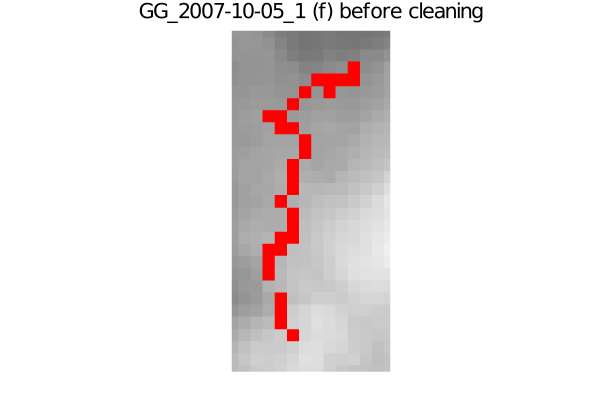

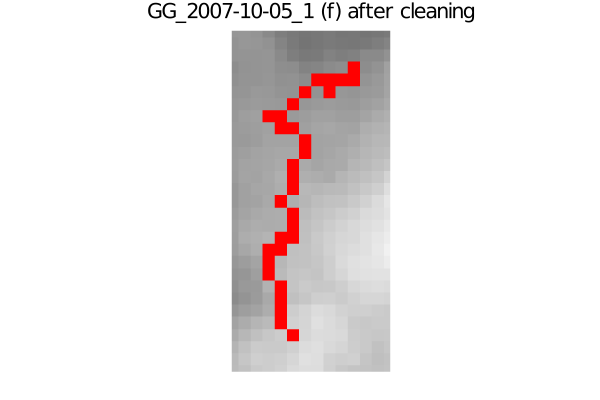

In [5]:
plot_path(points_grouped_f.i_xy[5], copy(elevation_map), points_grouped_f.segment[5] * " (f) before cleaning") |> display
plot_path(points_grouped_f.cells_actual[5], copy(elevation_map), points_grouped_f.segment[5] * " (f) after cleaning") |> display

Now we can go on and write a cost function (following Green et al. 2020) that we later apply to our modelled paths.

$$ costs(a, b) = \frac{(r_{a} + r_{b})}{2} * d_{S} * v * c $$

Our cost function for travel from patch A to directly adjacent patch B includes the vertical factor $v$ that expresses how much more energetically costly travel on a slope of the given incline is compared to a level surface and the surface distance $d_{S}$ that stands for the length of the slope. $r$ stands for the resistance of each cell, operationalised here as the costs of travel on different surfaces like THV patches and trails. $c$ is a correction factor that takes up the value of $\sqrt{2}$ if cells are diagonally connected to account for the greater distance between the two cell centre points (cf. Andriaesen et al. (2003), Green et al. (2020)). The vertical factor is derived from the study of Taylor et al. (1972), similarly to Green et al. (2020). 

Taylor et al. (1972) made chimpanzees run on a level surface, up- and downhill (15°) and measured oxygen consumption. For each of these, they reported a linear relationship between velocity ($v$) and oxygen consumption with different slopes (Taylor et al. 1972, Table 1).
$$ oxygen_{0°}(v) = 0.25 * v + 0.79 $$
$$ oxygen_{+15°}(v) = 0.44 * v + 0.85 $$
$$ oxygen_{-15°}(v) = 0.13 * v + 0.79 $$

We are interested in the degree of relative difference between walking on a surface of varying steepness in comparison to walking on a level surface. If we assume a mean velocity of 3 km/h, walking uphill (+15°) is 41% percent costlier than walking on a level surface ($\frac{oxygen_{+15°}(3)}{oxygen_{0°}(3)} = 1.41$), walking downhill is 33% less costly ($\frac{oxygen_{-15°}(3)}{oxygen_{0°}(3)} = 0.77$). If we assume a linear function that describes the relationship of steepness and energy expenditure, knowing that $f(15) = 1.41$ and $f(0) = 1$, we arrive at $uphill(deg) = 0.027 * deg + 1$. We extrapolate a linear function for values from 0 to -15 and set $r$ for values lower than that to $0.77$ (see function `vertical factor`).

We write a function for the vertical factor:

In [6]:
using Proj4
wgs84 = Projection("+proj=longlat +datum=WGS84 +no_defs")
utm36 = Projection("+proj=utm +zone=36 +north +datum=WGS84 +units=m +no_defs")

function distance(s::Tuple{Int,Int}, d::Tuple{Int,Int}) # geographic distance: we reproject to a local projection
    s_geo = Proj4.transform(wgs84, utm36, collect(GeoArrays.coords(elevation, [s...]))) # index coords -> geo coords in local projection
    d_geo = Proj4.transform(wgs84, utm36, collect(GeoArrays.coords(elevation, [d...])))
    return sqrt((s_geo[1] - d_geo[1]) ^ 2 + (s_geo[2] - d_geo[2]) ^ 2)
end

function hypot(a::Tuple{Int,Int}, b::Tuple{Int,Int})
    dist = distance(a, b) 
    alt_diff = elevation[b...][1] - elevation[a...][1] 
    hypotenuse = sqrt(dist ^ 2 + alt_diff ^ 2) # pythagoras' theorem
    incline = asin(alt_diff/hypotenuse) |> rad2deg # arcsine
    return (hypotenuse, incline)
end
    
function verticalfactor(incline::Float64) # index coords
    if incline > 0
        r = 0.027 * incline + 1
    elseif -15 <= incline < 0
        r =  0.015 * incline + 1
    elseif incline < -15
        r = 0.77
    else
        r = 0
    end
    return r
end

verticalfactor (generic function with 1 method)

Now, we look at the different surface types that we assign different costs to. The numerical values encoded in the `patches` and `trails` represent the following patch types:
- 1 - manmade trail
- 2 - elephant trail
- 3 - road
- 5 - logged areas
- 6 - thv patches
- 7 - papyrus

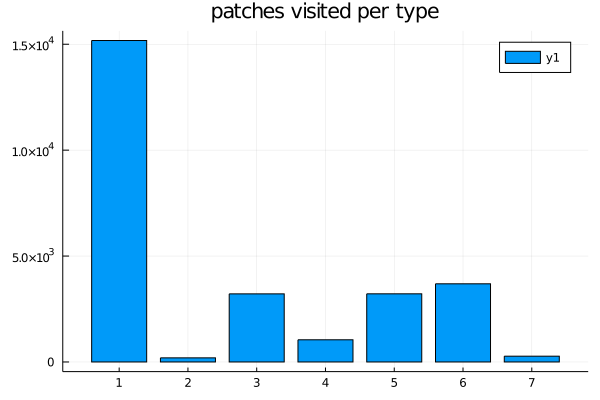

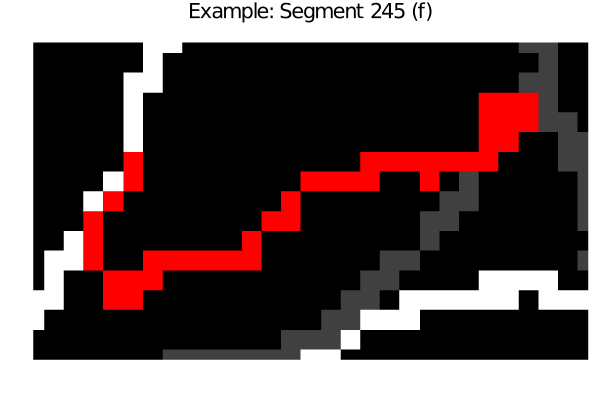

In [7]:
count_dict = Dict(1 => 0, 2 => 0, 3 => 0, 4 => 0, 5 => 0, 6 => 0, 7 => 0)
for c in points_f.i_xy
    p = patches[c...][1]
    t = trails[c...][1]
    !ismissing(p) && p > 0 && (count_dict[p] += 1)
    !ismissing(t) && t > 0 && (count_dict[t] += 1)
end
x_dict = map(x -> x[1], collect(count_dict))
y_dict = map(x -> x[2], collect(count_dict))
bar(x_dict, y_dict, title="patches visited per type") |> display

plot_path(points_grouped_f.cells_actual[246], copy(trails_map), "Example: Segment 245 (f)") |> display

In our attempt to model chimpanzee movement as a function of "landscape costs", we would need to know how exactly superstrate and substrate of e.g. a road affects energetic expenditure. Since we don't know that, we can only assume that travelling on trails is more convenient than through thick forest, for instance.

In [8]:
function surfacecosts(c::Tuple{Int, Int}, f::Float64) # index coords
    t = trails[c...][1]
    if !ismissing(t) && t == 1 # man-made trail
        ret = 1
    elseif !ismissing(t) && t == 2 # elephant trail
        ret = 1
    elseif !ismissing(t) && t == 3 # road
        ret = 1
    else
        ret = f
    end
    return ret
end

function costs(a::Tuple{Int,Int}, b::Tuple{Int,Int}, f::Float64) # see equation above
    diagonal(a, b) = a[1] != b[1] && a[2] != b[2] # are the cells diagonally connected?
    surface_dist, incline = hypot(a, b)
    return (surfacecosts(a, f) + surfacecosts(b, f))/2 * surface_dist * verticalfactor(incline) * (diagonal(a, b) ? sqrt(2) : 1) ###costs function!!!!
end

costs (generic function with 1 method)

Now we qrite a function to calculate the least-cost path from $s$ to $d$ using the A* search algorithm. In a weighted graph/grid, A* tries to minimise costs when it chooses the next node out of all neighbouring nodes based on the function $f(n) = g(n) + h(n)$, where $n$ is the next node, $g(n)$ is the cost of the path from $s$ to $n$ and $h(n)$ a heuristic that estimates the costs from $n$ to $d$. The heuristic function changes depending on the problem; if the goal is the shortest path, the Euclidean or Manhattan distance is usually chosen.

We apply the algorithm to all start-destination pairs in our data set and append the results to the DataFrame created above. We further compute least-cost paths for different parameter values for off-trail resistance.

In [9]:
using DataStructures

function reconstruct_path!(total_path::Array{Tuple{Int,Int}}, came_from::Array{Tuple{Int,Int}}, end_node::Tuple{Int,Int}) 
    current = end_node
    push!(total_path, current)
    while came_from[current...] != current
        pushfirst!(total_path, came_from[current...])
        current = came_from[current...]
    end
end

get_neighbours(current) = filter(x -> 0 < x[1] <= bounds[1] && 0 < x[2] <= bounds[2], [(current[1] + k[1], current[2] + k[2]) for k in [(0, -1), (0, 1), (-1, 0), (1, 0), (-1, -1), (-1, 1), (1, -1), (1, 1)]])

# https://github.com/JuliaGraphs/LightGraphs.jl/blob/master/src/shortestpaths/astar.jl
function astar(s::Tuple{Int,Int}, d::Tuple{Int,Int}, mode::String, heuristic::Function = x -> 0, p::Float64 = 1.0)
    
    open = PriorityQueue{Tuple{Int,Int}, Float64}()
    enqueue!(open, s, 0)

    closed = zeros(Bool, bounds)

    g = fill(Inf, bounds)
    g[s...] = 0

    came_from = fill((0,0), bounds)
    came_from[s...] = s
    
    total_path = Tuple{Int,Int}[]
    
    while !isempty(open)
        current = dequeue!(open)
        if current == d
            reconstruct_path!(total_path, came_from, current)
            return total_path
        end
        
        closed[current...] = true
        
        for n in get_neighbours(current)
            closed[n...] && continue
            tentative_g = g[current...] + (mode == "c" ? costs(current, n, p) : rand())
            if tentative_g < g[n...]
                g[n...] = tentative_g
                priority = tentative_g + (mode == "c" ? heuristic(n, d) : rand())
                open[n...] = priority
                came_from[n...] = current
            end
        end
    end
end

off_trail = [(1.0, "1"), (1.5, "1_5"), (2.0, "2"), (3.0, "3"), (4.0, "4"), (5.0, "5"), (6.0, "6"), 
    (7.0, "7"), (8.0, "8"), (9.0, "9"), (10.0, "10")]

for r in off_trail
    points_grouped_a["cells_lcp_" * r[2]] = [astar(x[1], x[end], "c", distance, r[1]) for x in points_grouped_a.i_xy]
    points_grouped_f["cells_lcp_" * r[2]] = [astar(x[1], x[end], "c", distance, r[1]) for x in points_grouped_f.i_xy];
end

Using the A* algorithm from above in combination with a random heuristic, we generate 100 random paths for each $s$ - $d$ pair.

In [10]:
random_paths_a = DataFrame(:iteration => collect(1:100))
random_paths_f = DataFrame(:iteration => collect(1:100))

costs_array(x::Array{Tuple{Int,Int},1}, f::Float64) = map(k -> costs(k[1], k[2], f), zip(x, x[2:end])) |> sum # points in array must be directly adjacent
distance_array(x::Array{Tuple{Int,Int},1}) = map(k -> distance(k[1], k[2]), zip(x, x[2:end])) |> sum
points_grouped_a.distance_straight = [distance(x[1], x[end]) for x in points_grouped_a.cells_actual]
points_grouped_f.distance_straight = [distance(x[1], x[end]) for x in points_grouped_f.cells_actual]

iterations = 100

function fill_array!(random_df::DataFrame, grouped_df::DataFrame)
    for s in grouped_df.segment
        random_df[s * "_distance"] = fill(0.0, nrow(random_df))
        random_df[s * "_sinuosity"] = fill(0.0, nrow(random_df))
        random_df[s * "_cells"] = fill(Tuple{Int,Int}[], nrow(random_df))
        for r in off_trail
            random_df[s * "_costs_" * r[2]] = fill(0.0, nrow(random_df))
            random_df[s * "_costs_per_m_" * r[2]] = fill(0.0, nrow(random_df))
        end
    end

    for (si, s) in enumerate(grouped_df.segment)
        for i in 1:iterations
            path = astar(grouped_df[si, :i_xy][1], grouped_df[si, :i_xy][end], "r")
            random_df[s * "_cells"][i] = path
            random_df[s * "_distance"][i] = distance_array(path)
            random_df[s * "_sinuosity"][i] = random_df[s * "_distance"][i]/grouped_df[si, :distance_straight]
            for r in off_trail
                random_df[s * "_costs_" * r[2]][i] = costs_array(path, r[1])
                random_df[s * "_costs_per_m_" * r[2]][i] = random_df[s * "_costs_" * r[2]][i]/random_df[s * "_distance"][i]
            end
        end
    end
end

fill_array!(random_paths_a, points_grouped_a)
fill_array!(random_paths_f, points_grouped_f)

In [14]:
p_lcp = plot_path(points_grouped_a.cells_lcp_2[48], copy(trails_map),  "LCP 2")
p_actual = plot_path(points_grouped_a.cells_actual[48], copy(trails_map), "AP")
p_random = plot_path(astar(points_grouped_a.i_xy[48][1], points_grouped_a.i_xy[48][end], "r"), copy(trails_map), "RAN")
p_straight = plot_path(points_grouped_a.cells_straight[48], copy(trails_map), "STR")

plot(p_actual, p_lcp, p_random, p_straight, layout = (2, 2), dpi=300)

savefig("paths.png")

For all of the modeled/actual paths, we calculate the total costs, travelled distance, costs per m and sinuosity.

In [12]:
using StatsBase

points_grouped_a.distance_actual = distance_array.(points_grouped_a.cells_actual)
points_grouped_a.distance_random = [mean(random_paths_a[s * "_distance"]) for s in points_grouped_a.segment]
points_grouped_a.sinuosity_actual = points_grouped_a.distance_actual ./ points_grouped_a.distance_straight
points_grouped_a.sinuosity_random = [mean(random_paths_a[s * "_sinuosity"]) for s in points_grouped_a.segment]
points_grouped_f.distance_straight = [distance(x[1], x[end]) for x in points_grouped_f.cells_actual]
points_grouped_f.distance_actual = distance_array.(points_grouped_f.cells_actual)
points_grouped_f.distance_random = [mean(random_paths_f[s * "_distance"]) for s in points_grouped_f.segment]
points_grouped_f.sinuosity_actual = points_grouped_f.distance_actual ./ points_grouped_f.distance_straight
points_grouped_f.sinuosity_random = [mean(random_paths_f[s * "_sinuosity"]) for s in points_grouped_f.segment]

for r in off_trail
    points_grouped_a["costs_straight_" * r[2]] = costs_array.(points_grouped_a.cells_straight, r[1])
    points_grouped_a["costs_actual_" * r[2]] = costs_array.(points_grouped_a.cells_actual, r[1])
    points_grouped_a["costs_lcp_" * r[2]] = costs_array.(points_grouped_a["cells_lcp_" * r[2]], r[1])
    points_grouped_a["costs_random_" * r[2]] = [mean(costs_array.(random_paths_a[s * "_cells"], r[1])) for s in points_grouped_a.segment]
    points_grouped_a["distance_lcp_" * r[2]] = distance_array.(points_grouped_a["cells_lcp_" * r[2]])
    points_grouped_a["costs_per_m_straight_" * r[2]] = points_grouped_a["costs_straight_" * r[2]] ./ points_grouped_a.distance_straight
    points_grouped_a["costs_per_m_actual_" * r[2]] = points_grouped_a["costs_actual_" * r[2]] ./ points_grouped_a.distance_actual
    points_grouped_a["costs_per_m_lcp_" * r[2]] = points_grouped_a["costs_lcp_" * r[2]] ./ points_grouped_a["distance_lcp_" * r[2]]
    points_grouped_a["costs_per_m_random_" * r[2]] = points_grouped_a["costs_random_" * r[2]] ./ points_grouped_a.distance_random
    points_grouped_a["sinuosity_lcp_" * r[2]] = points_grouped_a["distance_lcp_" * r[2]] ./ points_grouped_a.distance_straight 
    points_grouped_f["costs_straight_" * r[2]] = costs_array.(points_grouped_f.cells_straight, r[1])
    points_grouped_f["costs_actual_" * r[2]] = costs_array.(points_grouped_f.cells_actual, r[1])
    points_grouped_f["costs_lcp_" * r[2]] = costs_array.(points_grouped_f["cells_lcp_" * r[2]], r[1])
    points_grouped_f["costs_random_" * r[2]] = [mean(costs_array.(random_paths_f[s * "_cells"], r[1])) for s in points_grouped_f.segment]
    points_grouped_f["distance_lcp_" * r[2]] = distance_array.(points_grouped_f["cells_lcp_" * r[2]])
    points_grouped_f["costs_per_m_straight_" * r[2]] = points_grouped_f["costs_straight_" * r[2]] ./ points_grouped_f.distance_straight
    points_grouped_f["costs_per_m_actual_" * r[2]] = points_grouped_f["costs_actual_" * r[2]] ./ points_grouped_f.distance_actual
    points_grouped_f["costs_per_m_lcp_" * r[2]] = points_grouped_f["costs_lcp_" * r[2]] ./ points_grouped_f["distance_lcp_" * r[2]]
    points_grouped_f["costs_per_m_random_" * r[2]] = points_grouped_f["costs_random_" * r[2]] ./ points_grouped_f.distance_random
    points_grouped_f["sinuosity_lcp_" * r[2]] = points_grouped_f["distance_lcp_" * r[2]] ./ points_grouped_f.distance_straight
end
                        
colnames = filter(x -> occursin(r"(sinuosity|costs|distance)", x), names(points_grouped_a))

df_a = points_grouped_a[:, ["segment", colnames...]]
df_f = points_grouped_f[:, ["segment", colnames...]];

Lastly, we calculate the Path Deviation Index (PDI) for all LCP-AP and STR-AP pairs. We also calculate a mean PDI per segment for all random paths and the actual path.

The PDI is calculated by dividing the area encompassed by two paths (with the same start/end point by the straight line distance between start and end point. To get the normalised PDI, we divide the PDI by the straight line distance again.

As the two path can intersect and thus form a MultiPolygon, we calculate areas for each polygon formed by the two paths and adding up. Since we cannot deal with all special cases and noisy geometries using this approach, a few segments remain without PDI.

In [13]:
using LibGEOS

function calc_encompassed_area(cl1::Array{Array{Float64,1},1}, cl2::Array{Array{Float64,1},1}) # geo coords of two lines
    
    line1 = LineString(cl1)
    line2 = LineString(cl2)
    
    coords1 = LibGEOS.coordinates(line1)
    coords2 = LibGEOS.coordinates(line2)
    
    coords1[1] != coords2[1] && (return NaN)
    coords1[end] != coords2[end] && (return NaN)
    
    poly_coords = vcat(coords1, reverse(coords2))

    poly = LibGEOS.Polygon([poly_coords])
    
    return LibGEOS.area(poly)    
end

NPDI(a::Float64, d::Float64) = round((a / d) / d, digits=2) # pullinger johnson 2010

function calc_npdi_lcp!(df::DataFrame, df2::DataFrame)
    for r in off_trail
        df[:, "npdi_actual_lcp_" * r[2]] = fill(0.0, nrow(df))
    end
    for i in 1:nrow(df)
        cl1 = [Proj4.transform(wgs84, utm36, collect(GeoArrays.coords(elevation, [p...]))) for p in df2.cells_actual[i]]
        for r in off_trail
            cl2 = [Proj4.transform(wgs84, utm36, collect(GeoArrays.coords(elevation, [p...]))) for p in df2["cells_lcp_" * r[2]][i]]
            df[i, "npdi_actual_lcp_" * r[2]] = NPDI(calc_encompassed_area(cl1, cl2), df.distance_straight[i])
        end
    end
end

function calc_npdi(array1::Array{Array{Tuple{Int,Int},1},1}, array2::Array{Array{Tuple{Int,Int},1},1}, distance_array::Array{Float64,1})
    ret = fill(0.0, length(array1))
    for i in 1:length(array1)
        cl1 = [Proj4.transform(wgs84, utm36, collect(GeoArrays.coords(elevation, [p...]))) for p in array1[i]]
        cl2 = [Proj4.transform(wgs84, utm36, collect(GeoArrays.coords(elevation, [p...]))) for p in array2[i]]
        ret[i] = NPDI(calc_encompassed_area(cl1, cl2), distance_array[i])
    end
    return ret
end

calc_npdi_lcp!(df_a, points_grouped_a)
calc_npdi_lcp!(df_f, points_grouped_f)
df_a.npdi_actual_straight = calc_npdi(points_grouped_a.cells_actual, points_grouped_a.cells_straight, df_a.distance_straight)
df_f.npdi_actual_straight = calc_npdi(points_grouped_f.cells_actual, points_grouped_f.cells_straight, df_f.distance_straight)

df_a.npdi_actual_random = fill(0.0, nrow(df_a))
df_f.npdi_actual_random = fill(0.0, nrow(df_f))

for (si, s) in enumerate(df_a.segment)
    df_a.npdi_actual_random[si] = mean(calc_npdi(random_paths_a[s * "_cells"], fill(points_grouped_a[si, "cells_actual"], iterations), df_a.distance_straight))
    
end
for (si, s) in enumerate(df_f.segment)
    df_f.npdi_actual_random[si] = mean(calc_npdi(random_paths_f[s * "_cells"], fill(points_grouped_f[si, "cells_actual"], iterations), df_f.distance_straight))
end
                
CSV.write("model_output_a.csv", df_a)
CSV.write("model_output_f.csv", df_f)

"model_output_f.csv"